# RandomSearchCV with K-fold KNN Assignment

In [1]:
!pip install tqdm

mysql-connector-python 8.0.21 requires protobuf>=3.0.0, which is not installed.
distributed 1.21.8 requires msgpack, which is not installed.
You are using pip version 10.0.1, however version 20.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy
from tqdm import tqdm
import numpy as np
from sklearn.metrics.pairwise import euclidean_distances


x,y = make_classification(n_samples=10000, n_features=2, n_informative=2, n_redundant= 0, n_clusters_per_class=1, random_state=60)
x_train, x_test, y_train, y_test = train_test_split(x,y,stratify=y,random_state=42)


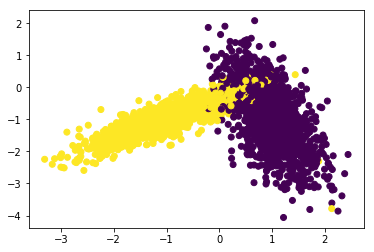

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
colors = {0:'red', 1:'blue'}
plt.scatter(x_test[:,0], x_test[:,1],c=y_test)
plt.show()

## Implementing Custom RandomSearchCV

In [4]:
import random

def get_KValues_In_Range(param_range, size):
    return sorted(random.sample(range(param_range[0], param_range[1]+1), size))

In [36]:
def get_Train_CV_lists(x_train, y_train, folds):
    k_fold_list_X = []
    k_fold_list_y = []
    list_size = int(len(x_train) / folds)
    lastIdx = 0
    
    for i in range(folds):
        list_x = [val for val in x_train[lastIdx : lastIdx + list_size]]
        list_y = [val for val in y_train[lastIdx : lastIdx + list_size]]
        k_fold_list_X.append(list_x)
        k_fold_list_y.append(list_y)
        lastIdx += list_size
        
    return k_fold_list_X, k_fold_list_y  

In [63]:
def custom_RandomSearch_CV(x_train, y_train, classifier, param_range, folds):
    """
    This function takes the training set, test set, classifier, range of k-values and value of k for k-fold validation.
    It will return a list of accuracy values using k-fold CV and kNN
    """
    
    # Initialize the training and cross-validation accuracies
    training_accuracies = []
    cross_validation_accuracies = []
    
    # 10 k-values in param_range
    k_values = get_KValues_In_Range(param_range, 10)

    
    # Get list of k-fold divided x_train
    k_fold_list_X, k_fold_list_y = get_Train_CV_lists(x_train, y_train, folds)
    
    # Proceed with each k-value
    for k in k_values:
        
        # Initialize training and cv accuracy list for a k-value with k-fold
        training_acc_fold = []
        cross_val_acc_fold = []

        # Compute for each k in k-fold for a k-value KNN
        for fold in range(folds):

            # Get training and cv set
            cv_set_x = k_fold_list_X[fold]
            cv_set_y = k_fold_list_y[fold]

            # Add rest of the sets to train set
            train_set_list_x = tuple([k_fold_list_X[f] for f in range(folds) if f != fold])
            train_set_list_y = tuple([k_fold_list_y[f] for f in range(folds) if f != fold])

            train_set_x = np.vstack(train_set_list_x)
            train_set_y = np.vstack(train_set_list_y).ravel()

            # Apply classifier
            classifier.n_neighbors = k
            classifier.fit(train_set_x, train_set_y)

            # Predict on training set and cv set
            train_set_pred = classifier.predict(train_set_x)
            cv_set_pred = classifier.predict(cv_set_x)

            # Compute accuracy and add them in training and cv accuracy list for a specific k-value
            training_acc_fold.append(accuracy_score(train_set_y, train_set_pred))
            cross_val_acc_fold.append(accuracy_score(cv_set_y, cv_set_pred))

        training_accuracies.append(np.mean(np.array(training_acc_fold)))   
        cross_validation_accuracies.append(np.mean(np.array(cross_val_acc_fold)))

    return k_values, training_accuracies, cross_validation_accuracies

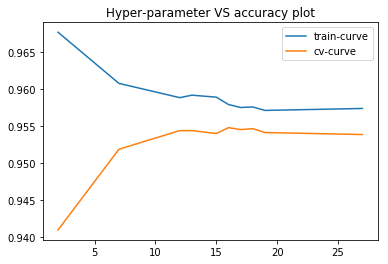

In [70]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Knn classifier
knn = KNeighborsClassifier()

# PAss training sets, classifier, k-range and fold size
k_values, train_accuracy, cv_accuracies = custom_RandomSearch_CV(x_train, y_train, knn, (1,30), 3)

# Plot training and cross-validation accuracy value with k-values
plt.plot(k_values, train_accuracy, label='train-curve')
plt.plot(k_values, cv_accuracies, label='cv-curve')
plt.title('Hyper-parameter VS accuracy plot')
plt.legend()
plt.show()

In [72]:
# K-value should be 16

# Plot decision surface
def plot_decision_boundary(X1, X2, y, clf):
    """This function takes the X1, X2 axis values to build a meshgrid and clf to classify
    and plot the decision surface. It uses X1,X2 and y value to do scatter plot
    """
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    x_min, x_max = X1.min() - 1, X1.max() + 1
    y_min, y_max = X2.min() - 1, X2.max() + 1
    
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    # Plot also the training points
    plt.scatter(X1, X2, c=y, cmap=cmap_bold)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("2-Class classification (k = %i)" % (clf.n_neighbors))
    plt.show()

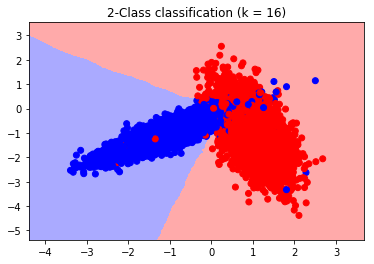

In [76]:
from matplotlib.colors import ListedColormap
neigh = KNeighborsClassifier(n_neighbors = 16)
neigh.fit(x_train, y_train)
plot_decision_boundary(x_train[:, 0], x_train[:, 1], y_train, neigh)